## Load thư viện và đọc dữ liệu

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"user_behavior_dataset.csv")
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


## Tiền xử lý

In [3]:
# Xóa cột dữ liệu không mong muốn
df.drop(columns='User ID', inplace=True, axis=1)

# Mã hóa biến phân loại
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns[df.dtypes=='object']:
    df[col] = le.fit_transform(df[col])

df.head()

,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,0,0,393,6.4,1872,67,1122,40,1,4
1,1,0,268,4.7,1331,42,944,47,0,3
2,3,0,154,4.0,761,32,322,42,1,2
3,0,0,239,4.8,1676,56,871,20,1,3
4,4,1,187,4.3,1367,58,988,31,0,3


In [4]:
# Chia tập dữ liệu làm 75% cho huấn luyện, 25% cho kiểm định

from sklearn.model_selection import train_test_split

def standardize(x):
    x = np.array(x)
    return (x - x.mean(axis=0)) / x.std(axis=0)

def split_standardize(df, label):
    x = df.drop(columns=label)
    y = df[label]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=20)
    x_train = standardize(x_train)
    x_test = standardize(x_test)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_standardize(df, label='User Behavior Class')

## Huấn luyện mô hình KNN

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Xây dựng mô hình

knn = KNeighborsClassifier()
params = {'n_neighbors': list(np.arange(2,32))}
model = RandomizedSearchCV(knn, random_state=20, 
                            scoring='accuracy',
                            param_distributions=params,
                            cv=10)

In [7]:
# Huấn luyện mô hình

def train(model, x_train, y_train):
    model.fit(x_train, y_train)
    print('Tham số tối ưu: ', model.best_params_)
    print('Accuracy: ', model.best_score_)
    return model.best_estimator_

nknn = train(model, x_train, y_train)

Tham số tối ưu:  {'n_neighbors': np.int64(3)}
Accuracy:  0.988534107402032


d:\projects\proj_ml\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Dự đoán dựa trên mô hình đã huấn luyện

In [8]:
# Dự đoán dựa trên mô hình đã huấn luyện
def predict(trained_model, x_test):
    return trained_model.predict(x_test)

y_pred = predict(nknn, x_test)

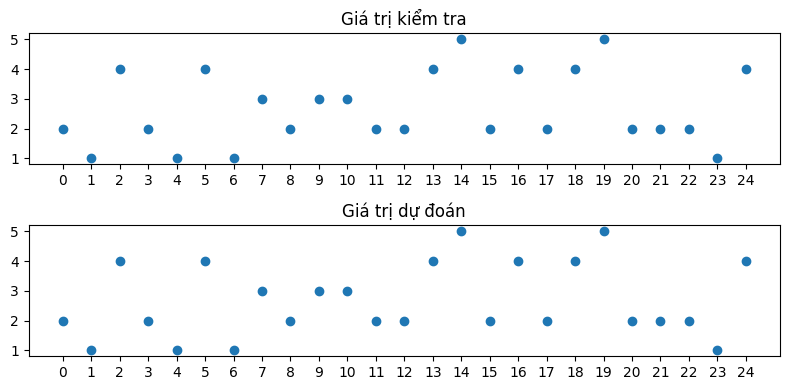

In [9]:
# Vẽ mẫu 25 điểm dữ liệu kiểm tra và dự đoán

def test_plot(y_test, y_pred):
    n = 25
    yticks = y_test.unique()
    fig, axes = plt.subplots(2, 1)
    fig.set_size_inches((8, 4))

    axes[0].scatter(range(n), y_test[0:n].values)
    axes[0].set_xticks(range(n))
    axes[0].set_yticks(yticks)
    axes[0].set_title('Giá trị kiểm tra')

    axes[1].scatter(range(n), y_pred[0:n])
    axes[1].set_xticks(range(n))
    axes[1].set_yticks(yticks)
    axes[1].set_title('Giá trị dự đoán')

    plt.tight_layout()
    plt.show()

test_plot(y_test, y_pred)

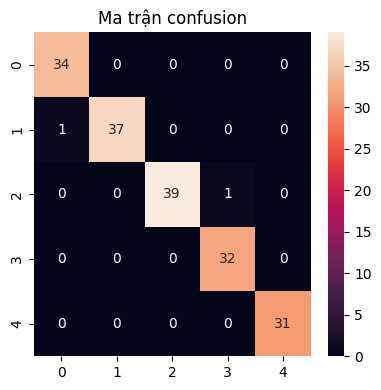

In [15]:
# Vẽ ma trận confusion
def confusion_plot(y_test, y_pred):
    fig, ax = plt.subplots()
    fig.set_size_inches((4, 4))
    sns.heatmap(confusion_matrix(y_pred, y_test), 
                annot=True, fmt='d', ax=ax)
    plt.title('Ma trận confusion')
    plt.tight_layout()
    plt.show()

confusion_plot(y_test, y_pred)

In [11]:
# Báo cáo hiệu suất phân loại
def report(y_test, y_pred):
    print(
        f"Báo cáo hiệu suất phân loại:\n"
        f"{classification_report(y_test, y_pred, digits=4)}\n"
    )

report(y_test, y_pred)

Báo cáo hiệu suất phân loại:
              precision    recall  f1-score   support

           1     1.0000    0.9714    0.9855        35
           2     0.9737    1.0000    0.9867        37
           3     0.9750    1.0000    0.9873        39
           4     1.0000    0.9697    0.9846        33
           5     1.0000    1.0000    1.0000        31

    accuracy                         0.9886       175
   macro avg     0.9897    0.9882    0.9888       175
weighted avg     0.9889    0.9886    0.9886       175




## Huấn luyện lại với các đặc trưng có tương quan lớn với ngõ ra

Tham số tối ưu:  {'n_neighbors': np.int64(15)}
Accuracy:  1.0


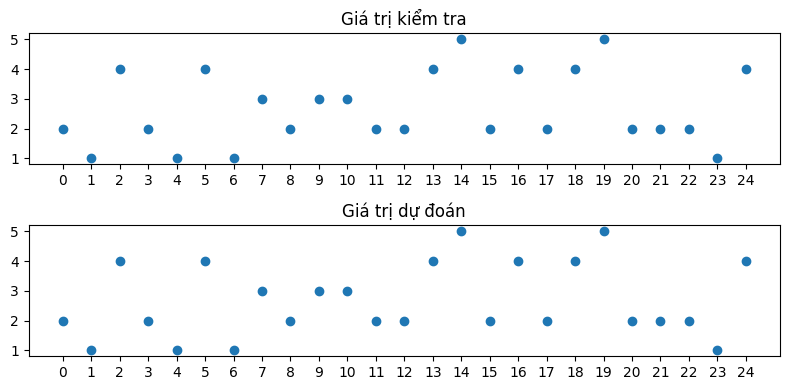

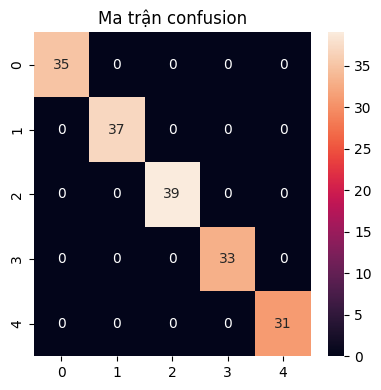

Báo cáo hiệu suất phân loại:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        35
           2     1.0000    1.0000    1.0000        37
           3     1.0000    1.0000    1.0000        39
           4     1.0000    1.0000    1.0000        33
           5     1.0000    1.0000    1.0000        31

    accuracy                         1.0000       175
   macro avg     1.0000    1.0000    1.0000       175
weighted avg     1.0000    1.0000    1.0000       175




In [16]:
# Chọn các đặc trưng có tương quan cao với ngõ ra
features = [
    'App Usage Time (min/day)', 
    'Screen On Time (hours/day)',
    'Battery Drain (mAh/day)', 
    'Number of Apps Installed',
    'Data Usage (MB/day)'
]
label = ['User Behavior Class']
df2 = df[features + label]

# Chia tập dữ liệu và chuẩn hóa
x_train2, x_test2, y_train2, y_test2 = split_standardize(df2, label='User Behavior Class')

# Huấn luyện mô hình
nknn2 = train(model, x_train2, y_train2)

# Dự đoán 
y_pred2 = predict(nknn2, x_test2)

# Vẽ mẫu các giá trị kiểm tra và dự đoán
test_plot(y_test2, y_pred2)

# Ma trận confusion
confusion_plot(y_test2, y_pred2)

# Báo cáo hiệu suất
report(y_test2, y_pred2)